## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128] ,bn_place='original'):
    """Code Here
    建立你的神經網路
    """
    if bn_place == 'original' or bn_place == 'aft_input_layer':
        input_layer = keras.layers.Input(input_shape)
        if bn_place == 'aft_input_layer':
            x = keras.layers.BatchNormalization()(input_layer)
        for i, n_units in enumerate(num_neurons):
            if i == 0 and bn_place != 'aft_input_layer':
                x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1))(input_layer)
                x = keras.layers.BatchNormalization()(x)
            elif i != 0 and bn_place != 'aft_input_layer':
                x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1))(x)
                x = keras.layers.BatchNormalization()(x)
            elif bn_place == 'aft_input_layer':
                x = keras.layers.Dense(units=n_units,activation="relu",name="hidden_layer"+str(i+1))(x)
    elif bn_place == 'bf_activate':
        input_layer = keras.layers.Input(input_shape)
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units,name="hidden_layer"+str(i+1))(input_layer)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            else:
                x = keras.layers.Dense(units=n_units,name="hidden_layer"+str(i+1))(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
EPOCHS = 50
BATCH_SIZE = [256,128,32,16,2]
MOMENTUM = 0.95
BN_PLACE = ['bf_activate','aft_input_layer']

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for bn_place in BN_PLACE:
    keras.backend.clear_session()
    print("Experiment on Batch Size=256 BN_place=%s" % (str(bn_place)))
    model = build_mlp(input_shape=x_train.shape[1:], bn_place=bn_place)
    model.summary()
    optimizer = keras.optimizers.SGD(nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=256, 
                validation_data=(x_test, y_test), shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
        
    exp_name_tag = 'BS=256;BN_place=%s' % (str(bn_place))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
for batch_size in BATCH_SIZE:
    keras.backend.clear_session()
    print("Experiment on Batch Size=%s BN_place=original" % (str(batch_size)))
    model = build_mlp(input_shape=x_train.shape[1:], bn_place='original')
    model.summary()
    optimizer = keras.optimizers.SGD(nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
                validation_data=(x_test, y_test), shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
        
    exp_name_tag = 'BS=%s;BN_place=original' % (str(batch_size))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment on Batch Size=256 BN_place=bf_activate
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
acti

Epoch 45/50
196/196 [==============================] - 7s 35ms/step - loss: 0.0521 - accuracy: 0.9828 - val_loss: 3.6990 - val_accuracy: 0.4878
Epoch 46/50
196/196 [==============================] - 7s 35ms/step - loss: 0.0454 - accuracy: 0.9844 - val_loss: 3.8621 - val_accuracy: 0.4700
Epoch 47/50
196/196 [==============================] - 7s 35ms/step - loss: 0.0366 - accuracy: 0.9886 - val_loss: 3.7277 - val_accuracy: 0.4923
Epoch 48/50
196/196 [==============================] - 7s 35ms/step - loss: 0.0338 - accuracy: 0.9900 - val_loss: 3.5692 - val_accuracy: 0.5042
Epoch 49/50
196/196 [==============================] - 7s 35ms/step - loss: 0.0296 - accuracy: 0.9912 - val_loss: 3.4927 - val_accuracy: 0.5108
Epoch 50/50
196/196 [==============================] - 7s 35ms/step - loss: 0.0273 - accuracy: 0.9920 - val_loss: 3.5721 - val_accuracy: 0.5086
Experiment on Batch Size=256 BN_place=aft_input_layer
Model: "functional_1"
____________________________________________________________

196/196 [==============================] - 7s 36ms/step - loss: 0.1240 - accuracy: 0.9579 - val_loss: 3.5266 - val_accuracy: 0.5324
Epoch 44/50
196/196 [==============================] - 7s 37ms/step - loss: 0.1228 - accuracy: 0.9587 - val_loss: 3.6619 - val_accuracy: 0.5331
Epoch 45/50
196/196 [==============================] - 9s 46ms/step - loss: 0.1144 - accuracy: 0.9612 - val_loss: 3.7568 - val_accuracy: 0.5312
Epoch 46/50
196/196 [==============================] - 8s 39ms/step - loss: 0.1056 - accuracy: 0.9643 - val_loss: 3.8257 - val_accuracy: 0.5359
Epoch 47/50
196/196 [==============================] - 8s 39ms/step - loss: 0.1007 - accuracy: 0.9665 - val_loss: 3.7991 - val_accuracy: 0.5309
Epoch 48/50
196/196 [==============================] - 7s 38ms/step - loss: 0.1076 - accuracy: 0.9632 - val_loss: 3.8313 - val_accuracy: 0.5338
Epoch 49/50
196/196 [==============================] - 8s 39ms/step - loss: 0.1116 - accuracy: 0.9628 - val_loss: 3.8455 - val_accuracy: 0.5309
Epoc

Epoch 40/50
196/196 [==============================] - 4s 22ms/step - loss: 0.3284 - accuracy: 0.8823 - val_loss: 3.0057 - val_accuracy: 0.4593
Epoch 41/50
196/196 [==============================] - 4s 22ms/step - loss: 0.3174 - accuracy: 0.8861 - val_loss: 2.6908 - val_accuracy: 0.4690
Epoch 42/50
196/196 [==============================] - 4s 22ms/step - loss: 0.3029 - accuracy: 0.8907 - val_loss: 2.6684 - val_accuracy: 0.4716
Epoch 43/50
196/196 [==============================] - 4s 22ms/step - loss: 0.2771 - accuracy: 0.9015 - val_loss: 2.7872 - val_accuracy: 0.4617
Epoch 44/50
196/196 [==============================] - 4s 23ms/step - loss: 0.2850 - accuracy: 0.8980 - val_loss: 3.0227 - val_accuracy: 0.4519
Epoch 45/50
196/196 [==============================] - 4s 23ms/step - loss: 0.2803 - accuracy: 0.8975 - val_loss: 2.8439 - val_accuracy: 0.4661
Epoch 46/50
196/196 [==============================] - 5s 23ms/step - loss: 0.2714 - accuracy: 0.9021 - val_loss: 2.7969 - val_accuracy:

Epoch 37/50
391/391 [==============================] - 6s 15ms/step - loss: 0.5365 - accuracy: 0.8075 - val_loss: 2.1657 - val_accuracy: 0.4805
Epoch 38/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5141 - accuracy: 0.8124 - val_loss: 2.1726 - val_accuracy: 0.4829
Epoch 39/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5062 - accuracy: 0.8163 - val_loss: 2.1167 - val_accuracy: 0.4915
Epoch 40/50
391/391 [==============================] - 6s 16ms/step - loss: 0.4932 - accuracy: 0.8211 - val_loss: 2.3615 - val_accuracy: 0.4704
Epoch 41/50
391/391 [==============================] - 6s 16ms/step - loss: 0.4795 - accuracy: 0.8260 - val_loss: 2.1567 - val_accuracy: 0.4799
Epoch 42/50
391/391 [==============================] - 6s 16ms/step - loss: 0.4754 - accuracy: 0.8290 - val_loss: 2.1833 - val_accuracy: 0.4965
Epoch 43/50
391/391 [==============================] - 6s 15ms/step - loss: 0.4503 - accuracy: 0.8364 - val_loss: 2.2428 - val_accuracy:

1563/1563 [==============================] - 14s 9ms/step - loss: 0.9985 - accuracy: 0.6421 - val_loss: 1.5188 - val_accuracy: 0.4951
Epoch 34/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9914 - accuracy: 0.6462 - val_loss: 1.4669 - val_accuracy: 0.5160
Epoch 35/50
1563/1563 [==============================] - 13s 9ms/step - loss: 0.9841 - accuracy: 0.6505 - val_loss: 1.5112 - val_accuracy: 0.5104
Epoch 36/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9752 - accuracy: 0.6516 - val_loss: 1.4564 - val_accuracy: 0.5229
Epoch 37/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9702 - accuracy: 0.6542 - val_loss: 1.5339 - val_accuracy: 0.4911
Epoch 38/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9609 - accuracy: 0.6562 - val_loss: 1.5128 - val_accuracy: 0.5111
Epoch 39/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9568 - accuracy: 0.6588 - val_loss: 1.4432 - val_accura

3125/3125 [==============================] - 24s 8ms/step - loss: 1.2952 - accuracy: 0.5411 - val_loss: 1.4177 - val_accuracy: 0.4969
Epoch 30/50
3125/3125 [==============================] - 24s 8ms/step - loss: 1.2894 - accuracy: 0.5430 - val_loss: 1.3952 - val_accuracy: 0.5044
Epoch 31/50
3125/3125 [==============================] - 24s 8ms/step - loss: 1.2843 - accuracy: 0.5449 - val_loss: 1.3764 - val_accuracy: 0.5180
Epoch 32/50
3125/3125 [==============================] - 24s 8ms/step - loss: 1.2926 - accuracy: 0.5420 - val_loss: 1.4027 - val_accuracy: 0.5085
Epoch 33/50
3125/3125 [==============================] - 24s 8ms/step - loss: 1.2744 - accuracy: 0.5472 - val_loss: 1.4877 - val_accuracy: 0.4910
Epoch 34/50
3125/3125 [==============================] - 24s 8ms/step - loss: 1.2766 - accuracy: 0.5480 - val_loss: 1.3413 - val_accuracy: 0.5286
Epoch 35/50
3125/3125 [==============================] - 24s 8ms/step - loss: 1.2667 - accuracy: 0.5534 - val_loss: 1.3846 - val_accurac

MemoryError: 

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "c", "silver", "tan", "orange"]

print(results.keys())

dict_keys(['BS=256;BN_place=bf_activate', 'BS=256;BN_place=aft_input_layer', 'BS=256;BN_place=original', 'BS=128;BN_place=original', 'BS=32;BN_place=original', 'BS=16;BN_place=original'])


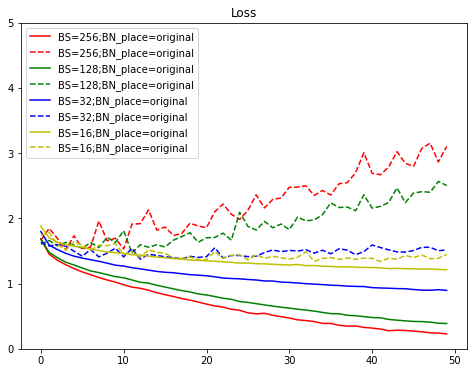

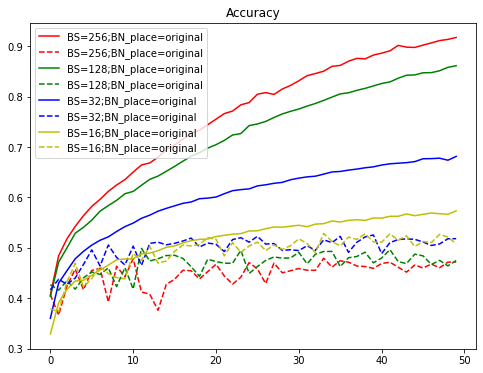

In [10]:
'print BATCH_SIZE = [2,16,32,128,256] BN_PLACE = [original]'
print_ = ['BS=256;BN_place=original', 'BS=128;BN_place=original', 'BS=32;BN_place=original', 'BS=16;BN_place=original']
plt.figure(figsize=(8,6))
for i, cond in enumerate(print_):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(print_):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

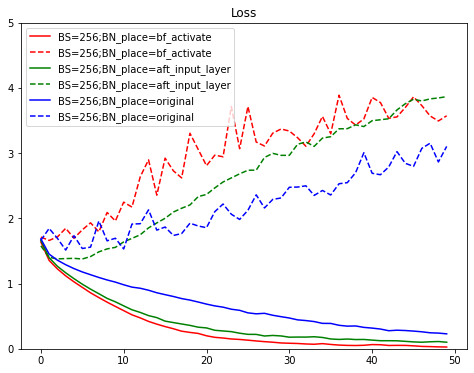

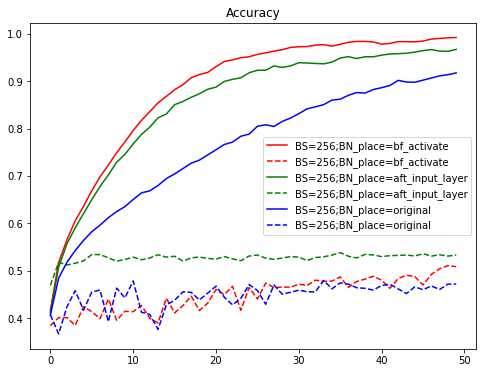

In [11]:
'print BATCH_SIZE = [256] BN_PLACE = [original,bf_activate,aft_input_layer]'
print_ = ['BS=256;BN_place=bf_activate', 'BS=256;BN_place=aft_input_layer', 'BS=256;BN_place=original']
plt.figure(figsize=(8,6))
for i, cond in enumerate(print_):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(print_):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()